Data provided hold the historical records of Opportunities (a potential deal with client). Opportunity is presented by the following (main) columns (properties): OpportunityId - to identify a separate Opportunity uniquely, CreatedDate - the date of the record creation, StageName - probability and the short stage description for a successful deal closing (100% Opportunity) Amount - (a current corrected version of) sum of the (potential) deal // ??? CloseDate - forecasted deal closing date Probability - the probability of success for this opportunity at its current stage other fields - properties of the Opportunity

You have the history of interactions with clients (Opportunity is a potential deal).
You should forecast the Probability of successful deal (Opportunity) closing.
Speaking more precisely, to forecast most likely next Probability using the known previous history for this Opportunity (potential deal), namely Stage + Probability changes in previous time.
Also you could use available properties of that Opportunity

In [113]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import tensorflow
from tensorflow import keras
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime

print(tensorflow.__version__)

2.8.0


In [114]:
df = pd.read_csv("train_data.csv")

C:\Users\Bohdan Potuzhnyi\AppData\Local\Temp\ipykernel_7728\933231161.py:1: DtypeWarning: Columns (14,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("train_data.csv")


In [115]:
missing_values_count = df.isnull().sum()
missing_values_count

Unnamed: 0                             0
Id                                     0
OpportunityId                          0
CreatedById                            0
CreatedDate                            0
CreatedDateForInsert                   0
StageName                              0
Amount                                 0
Probability                            0
PrevOpportunityStageUpdate             0
ValidThroughDate                    6954
SystemModstamp                         0
IsDeleted                              0
PrevAmount                         28705
PrevCloseDate                      27916
AccountId                              0
RecordTypeId                        1704
StageSortOrder                         0
Type                                   3
LeadSource                          5536
CampaignId                             0
OwnerId                                0
Territory2Id                           0
FiscalYear                             0
FiscalQuarter   

In [116]:
data = df[df['StageName'].str.contains('100%') | df['StageName'].str.contains('0% prob')]

#print(data.loc[(data.OpportunityId == "0061300001KubxZAAR")])

data.StageName = data.StageName.apply(lambda x: '1' if '100' in x else '0')



C:\Users\Bohdan Potuzhnyi\AppData\Local\Temp\ipykernel_7728\2232586543.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.StageName = data.StageName.apply(lambda x: '1' if '100' in x else '0')


<AxesSubplot:>

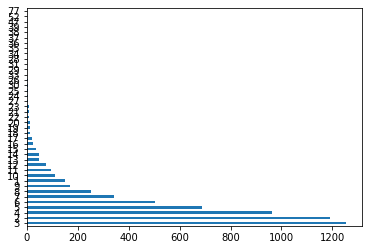

In [117]:
series = data.groupby("OpportunityId").OpportunityId.count()
series.sort_values(inplace=True)
series.head(3000)
series.value_counts().plot(kind = 'barh')
#opportunity_all = series["OpportunityId"]

In [118]:
print(series[-1])

77


In [119]:
all_opportunities = []
opp_longest = series[-1]

#used to fulfill np.array to be with max length
example_arr = []

for index, row in data.iterrows():
    #print(row)
    all_opportunities.append(row["OpportunityId"])
all_opportunities = np.unique(all_opportunities)
#print(all_opportunities)

In [120]:
### In this part for each opportunity from series DF i will create Array with all data that we
# get from functions described lower
# Firstly i will create array with all opportunities


#now create DF and convert it to array for each op from all opportunities and then push them all
# to one array
all_opportunities_array = []
final_probability_array = []
for opportunity in all_opportunities:
    opp_id = opportunity
    specific_opportinity = data.loc[(data.OpportunityId == opp_id)]
    #status = (specific_opportinity.loc[specific_opportinity.index[0], 'StageName'] == '1')
    # 1-success
    # 0-failure

    #print(status)
    specific_opportinity = specific_opportinity.sort_values(by="CreatedDateForInsert", ascending=True)
    #specific_opportinity

    #print(specific_opportinity)
    start_date = specific_opportinity.loc[specific_opportinity.index[0], "CreatedDate"]
    start_date = datetime.strptime(start_date, '%m/%d/%Y %H:%M')

    res_arr = []
    arr = []
    i = 0
    for current in specific_opportinity["CreatedDateForInsert"]:
        current_date = datetime.strptime(current, '%m/%d/%Y %H:%M')
        res_arr.append(int((current_date - start_date).days))
        if i == 0:
            arr.append(int((current_date - start_date).days))
            i+=1
        else:
            arr.append(int((current_date - start_date).days) - arr[i-1])
            i+=1

    specific_opportinity = specific_opportinity.loc[:, ["Amount", "Probability"]]
    specific_opportinity.insert(2, "Duration", res_arr)
    specific_opportinity.insert(3, "DeltaDuration", arr)
    final_probability = specific_opportinity.iloc[-1, specific_opportinity.columns.get_loc('Probability')]
    final_probability_array.append(final_probability)
    #print(final_probability)
    opp_array = np.array(specific_opportinity.iloc[-20:]).flatten()
    #print(opp_array)
    padding = np.ones(100) * 0.0
    op_ar_new = np.append(padding,opp_array)
    opp_array = op_ar_new[-80:]
    #print(opp_array)
    all_opportunities_array.append(opp_array)

###
# Okay array created now time for normalization i will create array with size of 20 x number of columns, 20 is choosed because 99% ended in 20 steps, and for deals that not ended at that time we will get last 20 events which will have enough information to give us understanding about deal and how it is going, it's pretty similar to how facebook acts, it's only checking for your last actions and reactions.
# after making this normalization i will be able to put this array in to tensor as series(20, columns) and than teach it
# plans changed



KeyboardInterrupt: 

In [ ]:
#print(all_opportunities_array[:2])
#print(final_probability_array[:2])
all_opportunities_array1 = np.asarray(all_opportunities_array)
final_probability_array1 = np.asarray(final_probability_array)
print(all_opportunities_array1[1])
print(final_probability_array1[1])
#final_probability_array

In [ ]:
batch_size = 32
all_opportunities_array11 = all_opportunities_array1.batch(batch_size)

In [123]:
def base_model():
  inputs = tensorflow.keras.Input(shape=(80,))
  x = tensorflow.keras.layers.Dense(256, activation='relu')(inputs)
  x = tensorflow.keras.layers.Dense(256, activation='relu')(x)
  outputs = tensorflow.keras.layers.Dense(100, activation='softmax')(x)
  model = tensorflow.keras.Model(inputs=inputs, outputs=outputs)
  return model

In [124]:
optimizer = tensorflow.keras.optimizers.Adam()
loss_object = tensorflow.keras.losses.MeanSquaredError()
model = base_model()
model.compile(optimizer=optimizer, loss=loss_object, metrics=[tensorflow.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 80)]              0         
                                                                 
 dense_44 (Dense)            (None, 256)               20736     
                                                                 
 dense_45 (Dense)            (None, 256)               65792     
                                                                 
 dense_46 (Dense)            (None, 100)               25700     
                                                                 
Total params: 112,228
Trainable params: 112,228
Non-trainable params: 0
_________________________________________________________________


In [125]:
def train_step(x, y):
  with tensorflow.GradientTape() as tape:
    pred = model(x)
    loss = model.compiled_loss(y, pred)
    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return tensorflow.linalg.global_norm(gradients)

In [127]:
epoch_num = 10
grad_norm = []
for epoch in range(epoch_num):
  for i in range(all_opportunities_array1.size):
    x = all_opportunities_array1[i]
    y = final_probability_array1[i]
    grad_norm.append(train_step(x,y))


ValueError: Exception encountered when calling layer "model_3" (type Functional).

Input 0 of layer "dense_44" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (80,)

Call arguments received:
  • inputs=tf.Tensor(shape=(80,), dtype=float64)
  • training=None
  • mask=None

In [ ]:
data_model = tensorflow.keras.Sequential(
    [
        tensorflow.keras.layers.Dense(256),
        tensorflow.keras.layers.Dense(256),
        tensorflow.keras.layers.Dense(128),
        tensorflow.keras.layers.Dense(1)
    ]
)

data_model.compile(loss = tensorflow.losses.MeanSquaredError(),
                   optimizer = tensorflow.optimizers.Adam())

data_model.fit(all_opportunities_array1, final_probability_array1, epochs = 100000)

In [ ]:
specific_opportinity.drop_duplicates(subset=['Duration'], inplace=True)
specific_opportinity

In [ ]:
sns.heatmap(specific_opportinity.corr('pearson'), annot=True, fmt='.2f')

In [ ]:
#sns.barplot(x="Duration", y="Probability", data=specific_opportinity)
#sns.scatterplot(x="Duration", y="Probability", data=specific_opportinity)

regressor = RandomForestRegressor(n_estimators=500, random_state=0)

In [ ]:
plt.figure(figsize=(20,7))
X = specific_opportinity['Duration'].values[:,np.newaxis]
# target data is array of shape (n,) 
y = specific_opportinity['Probability'].values

regressor.fit(X, y)

y_prediction_forest = regressor.predict(X)
sns.scatterplot(x=specific_opportinity['Duration'], y = y)
sns.lineplot(x=specific_opportinity['Duration'], y = y_prediction_forest)

print('score -> ', regressor.score(X, y))